In [486]:
import pandas as pd
from scipy.stats import iqr, gmean, kurtosis, skew
import matplotlib.pyplot as plt
import numpy as np

In [487]:
weights_df = pd.read_csv("../1. Inspect, Clean and Validate Dataset/CleanedData/Cleaned_WeightsAndCalories.csv")
nutrition_df = pd.read_csv("../1. Inspect, Clean and Validate Dataset/CleanedData/Cleaned_NutritionalData.csv")
strava_df = pd.read_csv("../1. Inspect, Clean and Validate Dataset/CleanedData/Cleaned_Strava.csv")

We need to remove the rows with a high carbohydrate intake. Carbohydrates are known for their ability to carry water.
1. we need to load the nutritional data set.
2. remove the rows with carb content over x grams
    - we may also need to aggregate the data so there is only one date
    - nutritional = nutritional.groupby["Date"]["Carbohydrates (g)"].sum()
3. Merge with weights_df. we need to drop all rows which dont align with the nutritional df
    - newdf = pd.merge(weights_df, nutritional_df, left_on="Date", right_on="Date", how="right")

In [488]:
nutrition_df["Date"] = pd.to_datetime(nutrition_df["Date"], errors="coerce", format="%Y-%m-%d")

nutrition_df["Total Calories In"] = np.round(nutrition_df.groupby("Date")["Calories"].transform("sum"))
nutrition_df["Total Fat In (g)"] = nutrition_df.groupby("Date")["Fat (g)"].transform("sum")
nutrition_df["Total Carbohydrates In (g)"] = nutrition_df.groupby("Date")["Carbohydrates (g)"].transform("sum")
nutrition_df["Total Protein In (g)"] = nutrition_df.groupby("Date")["Protein (g)"].transform("sum")

nutrition_df = nutrition_df[["Date", "Total Calories In", "Total Fat In (g)", "Total Carbohydrates In (g)", "Total Protein In (g)"]]
nutrition_df = nutrition_df.drop_duplicates(subset="Date").reset_index(drop=True)
total_records = len(nutrition_df)
print(total_records)
nutrition_df

1419


,Date,Total Calories In,Total Fat In (g),Total Carbohydrates In (g),Total Protein In (g)
0,2020-12-14,535.0,2.2,98.5,22.1
1,2020-12-15,1344.0,91.4,60.4,40.8
2,2020-12-16,1255.0,45.8,144.3,57.8
3,2020-12-17,2257.0,101.2,222.7,111.6
4,2020-12-18,2236.0,110.3,201.3,123.9
...,...,...,...,...,...
1414,2025-08-11,2653.0,176.4,123.5,149.2
1415,2025-08-12,2786.0,200.6,133.4,89.3
1416,2025-08-13,2890.0,214.6,113.8,128.0
1417,2025-08-14,2895.0,232.7,54.6,151.2


In [489]:
# Drop rows over x total carbs
x_carbohydrates = 100
nutrition_df = nutrition_df[nutrition_df["Total Carbohydrates In (g)"] <= x_carbohydrates]
nutrition_df = nutrition_df.reset_index(drop=True)
total_days_under_x_carbs = len(nutrition_df)
print(total_days_under_x_carbs)
nutrition_df

678


,Date,Total Calories In,Total Fat In (g),Total Carbohydrates In (g),Total Protein In (g)
0,2020-12-14,535.0,2.2,98.5,22.1
1,2020-12-15,1344.0,91.4,60.4,40.8
2,2020-12-21,715.0,23.8,78.0,66.2
3,2021-01-11,202.0,4.8,36.2,2.7
4,2021-01-15,204.0,9.0,29.4,2.4
...,...,...,...,...,...
673,2025-08-08,2879.0,82.9,37.3,41.2
674,2025-08-09,2864.0,222.3,69.6,145.2
675,2025-08-10,2498.0,189.0,59.6,148.0
676,2025-08-14,2895.0,232.7,54.6,151.2


Next, we need to merge the nutrition_df and weights_df. We should only keep records from nutritional_df days

In [490]:
weights_df = weights_df[["Date", "Weight, kg", "Calories In"]]
weights_df["Date"] = pd.to_datetime(weights_df["Date"], errors="coerce", format="%d/%m/%Y")

In [491]:
master_df = pd.merge(weights_df, nutrition_df, left_on="Date", right_on="Date", how="inner")
master_df = master_df[["Date", "Weight, kg", "Total Calories In", "Total Carbohydrates In (g)"]]
num_weight_nutritional_records = len(master_df)
print(num_weight_nutritional_records)
master_df

501


,Date,"Weight, kg",Total Calories In,Total Carbohydrates In (g)
0,2020-12-21,51.4,715.0,78.0
1,2021-02-09,53.3,785.0,98.9
2,2021-03-01,54.7,280.0,64.0
3,2021-04-18,56.2,760.0,90.2
4,2022-04-09,60.5,600.0,80.8
...,...,...,...,...
496,2025-08-08,65.9,2879.0,37.3
497,2025-08-09,66.3,2864.0,69.6
498,2025-08-10,65.9,2498.0,59.6
499,2025-08-14,67.2,2895.0,54.6


We now need to merge master_df with strava_df. This will let us identify days with no exercise vs days with exercise

In [492]:
strava_df["Activity Date"] = pd.to_datetime(strava_df["Activity Date"], errors="coerce", format="%Y-%m-%d")
strava_df = strava_df[["Activity Date", "Calories"]]
strava_df = strava_df.dropna().reset_index(drop=True)
unique_strava_df = strava_df.groupby("Activity Date")["Calories"].sum()
unique_strava_df = unique_strava_df.rename("Exercise Calories Burned")
type(unique_strava_df)
unique_strava_df.head()

Activity Date
2021-06-19    596.0
2023-05-02    175.0
2023-05-03     59.0
2023-05-04    132.0
2023-05-05     83.0
Name: Exercise Calories Burned, dtype: float64

In [493]:
master_df = pd.merge(master_df, strava_df, left_on="Date", right_on="Activity Date", how="left")
master_df = master_df.rename(columns={"Calories": "Exercise Calories Burned"})
master_df

,Date,"Weight, kg",Total Calories In,Total Carbohydrates In (g),Activity Date,Exercise Calories Burned
0,2020-12-21,51.4,715.0,78.0,NaT,NaN
1,2021-02-09,53.3,785.0,98.9,NaT,NaN
2,2021-03-01,54.7,280.0,64.0,NaT,NaN
3,2021-04-18,56.2,760.0,90.2,NaT,NaN
4,2022-04-09,60.5,600.0,80.8,NaT,NaN
...,...,...,...,...,...,...
658,2025-08-14,67.2,2895.0,54.6,2025-08-14,368.0
659,2025-08-14,67.2,2895.0,54.6,2025-08-14,145.0
660,2025-08-14,67.2,2895.0,54.6,2025-08-14,311.0
661,2025-08-15,66.9,2608.0,49.7,2025-08-15,95.0


Activity Date column can be dropped given that it is the same as the Date column

In [494]:
master_df = master_df[["Date", "Weight, kg", "Total Calories In", "Exercise Calories Burned"]].reset_index(drop=True)
master_df.loc[:, "Exercise Calories Burned"] = master_df["Exercise Calories Burned"].fillna(0)

Remove outliers from exercise data, remove outliers from daily weight change

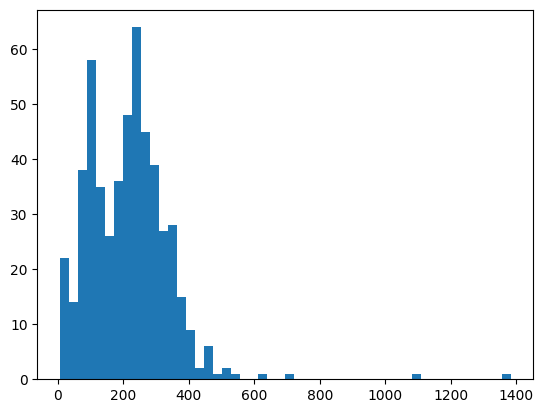

Skew: 2.3450326106707013 / Kurtosis: 17.06997923898362


In [495]:
did_exercise = master_df[master_df["Exercise Calories Burned"] > 0]
plt.hist(did_exercise["Exercise Calories Burned"], bins=50)
plt.show()
plt.close()

skew_score = skew(did_exercise["Exercise Calories Burned"])
kurtosis_score = kurtosis(did_exercise["Exercise Calories Burned"])
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

Distribution of Column: "Exercise Calories Burned"

Shape: Right, positively skewed. Most values range from 150-400, with a long right tail up to 1400

Mode: Tallest bars are at ~150 and ~350

Spread: Majority of the data values are between 150-400 calories, however there are some more extreme values at 600, 1100 and 1400

Outliers: A few high data points with values that are multiple times the median

Skewness Score: ~2.3 (Right skew)

Kurtosis Score: ~17.1 (Greater than 3, high peak and heavy tails)

I'll attempt to remove outliers with the IQR*1.5 rule

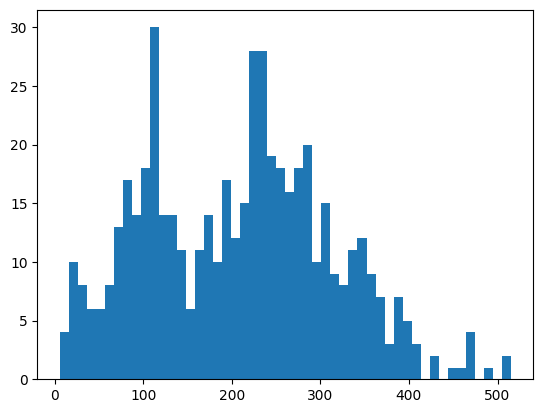

Skew: 0.18763422116338394 / Kurtosis: -0.5413786349707634


In [496]:
Q1 = did_exercise["Exercise Calories Burned"].quantile(0.25)
Q3 = did_exercise["Exercise Calories Burned"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
did_exercise = did_exercise[(did_exercise["Exercise Calories Burned"] >= lower_bound) & (did_exercise["Exercise Calories Burned"] <= upper_bound)]

plt.hist(did_exercise["Exercise Calories Burned"], bins=50)
plt.show()
plt.close()

skew_score = skew(did_exercise["Exercise Calories Burned"])
kurtosis_score = kurtosis(did_exercise["Exercise Calories Burned"])
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

We need to calculate daily weight change, but we need to remember that we don't have records for every day.

If for each day0:
    day1_weight_change = day1["Weight, kg"] - day0["Weight, kg"]
then we need to be sure that day1 exists

In [497]:
master_df.loc[:, "Previous Weight"] = master_df["Weight, kg"].shift(1)
master_df.loc[:, "Previous Date"] = master_df["Date"].shift(1)

# find difference only if days are consecutive
master_df["Daily Weight Change"] = (
    master_df["Weight, kg"] - master_df["Previous Weight"]
).where((master_df["Date"] - master_df["Previous Date"]).dt.days == 1)

master_df = master_df.drop(columns=["Previous Weight", "Previous Date"])
master_df = master_df.dropna()
master_df

,Date,"Weight, kg",Total Calories In,Exercise Calories Burned,Daily Weight Change
8,2023-05-10,60.8,2328.0,0.0,0.5
9,2023-05-11,60.6,2564.0,151.0,-0.2
10,2023-05-12,60.4,2471.0,51.0,-0.2
11,2023-05-13,60.7,1791.0,0.0,0.3
12,2023-05-14,59.8,2361.0,0.0,-0.9
...,...,...,...,...,...
652,2025-08-05,65.8,2958.0,98.0,-0.2
653,2025-08-06,65.7,2886.0,291.0,-0.1
655,2025-08-09,66.3,2864.0,308.0,0.4
656,2025-08-10,65.9,2498.0,100.0,-0.4


Remove outliers from Daily Weight Change

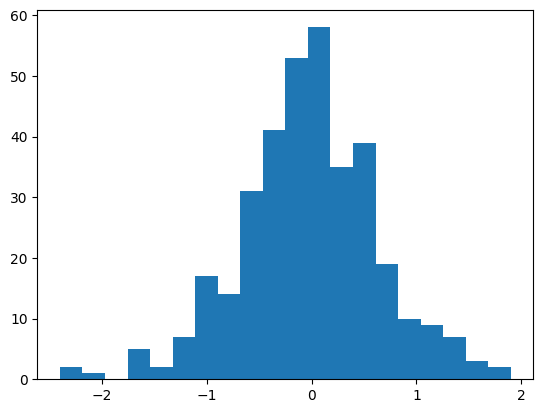

Skew: -0.16576371921288813 / Kurtosis: 0.9567868850226953


In [498]:
weight_changes = master_df.copy()
plt.hist(weight_changes["Daily Weight Change"], bins=20)
plt.show()
plt.close()

skew_score = skew(weight_changes["Daily Weight Change"])
kurtosis_score = kurtosis(weight_changes["Daily Weight Change"])
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

Distribution of Column: "Daily Weight Change"

Shape: Roughly symmetrical

Mode: Mode of 0

Spread: Most values are between +/-1.5. Much tighter spread than the previous distribution for Exercise Calories Burned

Outliers: Some potential outliers on the left tail, (below -2)

Skewness Score: ~-0.17 (Left skew)

Kurtosis Score: ~0.96 (Greater than 0, less than 3, higher peak and with some tails)

I'll attempt to remove outliers with the IQR*1.5 rule

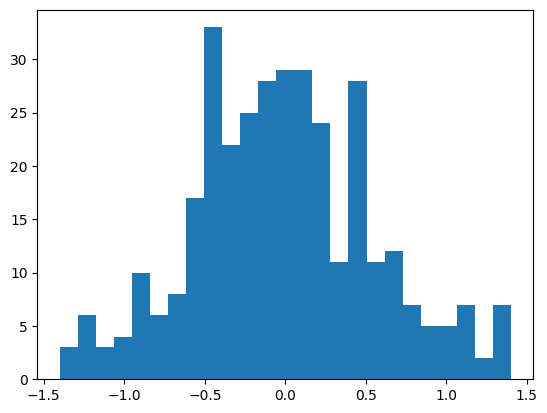

Skew: 0.15218189815650107 / Kurtosis: -0.08369529522669694


In [499]:
Q1 = weight_changes["Daily Weight Change"].quantile(0.25)
Q3 = weight_changes["Daily Weight Change"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
weight_changes = weight_changes[(weight_changes["Daily Weight Change"] >= lower_bound) & (weight_changes["Daily Weight Change"] <= upper_bound)]

plt.hist(weight_changes["Daily Weight Change"], bins=25)
plt.show()
plt.close()

skew_score = skew(weight_changes["Daily Weight Change"])
kurtosis_score = kurtosis(weight_changes["Daily Weight Change"])
print(f"Skew: {skew_score} / Kurtosis: {kurtosis_score}")

master_df["Daily Weight Change"] = weight_changes["Daily Weight Change"]

Drop rows where Daily Weight Change is NaN

In [500]:
master_df = master_df.dropna().reset_index(drop=True)
# master_df = master_df[["Date", "Daily Weight Change"]]

In [501]:
na_rows = master_df[master_df.isna().any(axis=1)]
na_rows

,Date,"Weight, kg",Total Calories In,Exercise Calories Burned,Daily Weight Change


How many rows are there where I did exercise vs where I didn't exercise?

In [502]:
exercise_baseline_cals_burned = 150
did_exercise = master_df[master_df["Exercise Calories Burned"] > exercise_baseline_cals_burned]
no_exercise = master_df[master_df["Exercise Calories Burned"] == 0]

print(f"When eating under {x_carbohydrates} carbs per day, there were:")
print(f"{len(did_exercise)} records where I did exercise (exercise calories > {exercise_baseline_cals_burned}). {len(no_exercise)} records where I did not do any exercise")

When eating under 100 carbs per day, there were:
180 records where I did exercise (exercise calories > 150). 78 records where I did not do any exercise


In [503]:
min_val = did_exercise["Total Calories In"].min()
max_val = did_exercise["Total Calories In"].max()

bin_size = 10
bins = np.arange(start=min_val, stop=max_val + 10, step=bin_size)

# Optional: create labels like "0-10", "11-20", ...
labels = [f"{int(bins[i])}-{int(bins[i+1]-1)}" for i in range(len(bins)-1)]

# Create the binned column
did_exercise.loc[:, "Calories Group"] = pd.cut(did_exercise["Total Calories In"], bins=bins, labels=labels, include_lowest=True)
no_exercise.loc[:, "Calories Group"] = pd.cut(no_exercise["Total Calories In"], bins=bins, labels=labels, include_lowest=True)
did_exercise


C:\Users\harri\AppData\Local\Temp\ipykernel_20560\188454708.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_exercise.loc[:, "Calories Group"] = pd.cut(did_exercise["Total Calories In"], bins=bins, labels=labels, include_lowest=True)
C:\Users\harri\AppData\Local\Temp\ipykernel_20560\188454708.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_exercise.loc[:, "Calories Group"] = pd.cut(no_exercise["Total Calories In"], bins=bins, labels=labels, include_lowest=True)


,Date,"Weight, kg",Total Calories In,Exercise Calories Burned,Daily Weight Change,Calories Group
1,2023-05-11,60.6,2564.0,151.0,-0.2,2560-2569
5,2023-05-15,60.6,2825.0,289.0,0.8,2820-2829
6,2023-05-16,60.8,2998.0,249.0,0.2,2990-2999
8,2023-05-26,61.1,2615.0,163.0,0.1,2610-2619
17,2023-06-07,62.5,2204.0,326.0,-0.9,2200-2209
...,...,...,...,...,...,...
318,2025-04-28,60.7,2270.0,246.0,-0.1,2260-2269
329,2025-06-04,63.5,1922.0,172.0,-0.2,1920-1929
331,2025-07-16,64.6,3185.0,151.0,-0.4,3180-3189
338,2025-08-06,65.7,2886.0,291.0,-0.1,2880-2889


In [504]:
no_exercise.loc[:, "counts"] = no_exercise["Calories Group"].map(
    no_exercise["Calories Group"].value_counts()
)
did_exercise.loc[:, "counts"] = did_exercise["Calories Group"].map(
    did_exercise["Calories Group"].value_counts()
)
no_exercise

C:\Users\harri\AppData\Local\Temp\ipykernel_20560\846463159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_exercise.loc[:, "counts"] = no_exercise["Calories Group"].map(
C:\Users\harri\AppData\Local\Temp\ipykernel_20560\846463159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_exercise.loc[:, "counts"] = did_exercise["Calories Group"].map(


,Date,"Weight, kg",Total Calories In,Exercise Calories Burned,Daily Weight Change,Calories Group,counts
0,2023-05-10,60.8,2328.0,0.0,0.5,2320-2329,1.0
3,2023-05-13,60.7,1791.0,0.0,0.3,1790-1799,1.0
4,2023-05-14,59.8,2361.0,0.0,-0.9,2360-2369,1.0
7,2023-05-19,61.2,1985.0,0.0,0.0,1980-1989,1.0
10,2023-05-28,61.7,2624.0,0.0,-0.4,2620-2629,1.0
...,...,...,...,...,...,...,...
326,2025-05-16,61.3,2640.0,0.0,0.1,2630-2639,1.0
327,2025-05-26,62.7,351.0,0.0,-0.4,NaN,NaN
328,2025-05-27,63.5,2500.0,0.0,0.8,2490-2499,5.0
330,2025-07-09,65.1,1065.0,0.0,-0.3,1060-1069,1.0


In [505]:
did_exercise

,Date,"Weight, kg",Total Calories In,Exercise Calories Burned,Daily Weight Change,Calories Group,counts
1,2023-05-11,60.6,2564.0,151.0,-0.2,2560-2569,3
5,2023-05-15,60.6,2825.0,289.0,0.8,2820-2829,1
6,2023-05-16,60.8,2998.0,249.0,0.2,2990-2999,2
8,2023-05-26,61.1,2615.0,163.0,0.1,2610-2619,2
17,2023-06-07,62.5,2204.0,326.0,-0.9,2200-2209,3
...,...,...,...,...,...,...,...
318,2025-04-28,60.7,2270.0,246.0,-0.1,2260-2269,1
329,2025-06-04,63.5,1922.0,172.0,-0.2,1920-1929,1
331,2025-07-16,64.6,3185.0,151.0,-0.4,3180-3189,1
338,2025-08-06,65.7,2886.0,291.0,-0.1,2880-2889,1


In [506]:
valid_records = pd.merge(did_exercise, no_exercise, on=["Date","Weight, kg", "Daily Weight Change", "Total Calories In","Calories Group", "Exercise Calories Burned"], suffixes=["_de", "_ne"], how="outer")
valid_records["counts_de"] = valid_records["counts_de"].fillna(0)
valid_records["counts_ne"] = valid_records["counts_ne"].fillna(0)
valid_records = valid_records[["Date", "Total Calories In", "Calories Group", "Exercise Calories Burned", "counts_de", "counts_ne"]].sort_values("Calories Group").reset_index(drop=True)

In [507]:
no_e = no_exercise["Calories Group"].value_counts()
did_e = did_exercise["Calories Group"].value_counts()
new_e = pd.merge(did_e.to_frame(), no_e.to_frame(), on="Calories Group", suffixes=["_de", "_ne"])
new_e["Minimum"] = np.minimum(new_e["count_de"], new_e["count_ne"]) # new_e["Minimum"] represents the most records to take from both sample groups
new_e = new_e[new_e["Minimum"] > 0][["Minimum"]]

In [508]:
new_e["Minimum"].sum()
print(f"So there is {new_e["Minimum"].sum()} total rows for each group that i can get records from")

So there is 48 total rows for each group that i can get records from


In [509]:
valid_records.to_csv("./Selecting Records for Analysis/Valid Records.csv")
new_e.to_csv("./Selecting Records for Analysis/Num Records Per Group.csv")